# 实验三 AR模型
实验内容:
    一、模拟 AR 模型并估计模型的参数；
    二、实际的数据建模及估计参数。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import statsmodels
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
%matplotlib inline

![](img/3_1.png)

ar_args是AR模型的系数，例如$X_t=1.5X_{t-1}-0.75X_{t-2}+e_t$的系数为[1,-1.5,0.75]
n是生成的时间序列的长度，bn是丢弃的前面的数据，因为前面的数据不是平稳的

In [89]:
#生成模拟数据
def generate_ar_data(ar_args,n,bn):
    ma_args=np.array([1])
    ar_process=ArmaProcess(ar_args,ma_args)
    simulated_raw_data=ar_process.generate_sample(nsample=n)
    return simulated_raw_data[bn:]
def plot_ar_data(data):
    plt.plot(data)
    plt.title('Time Series Plot of Simulated AR Process')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
def plot_acf_pacf(data):
    plot_acf(data)
    plt.xlabel('Lag')
    plt.ylabel('ACF')
    plt.show()
    plot_pacf(data)
    plt.xlabel('Lag')
    plt.ylabel('PACF')
    plt.show()
ar_args=np.array([1,-1.5,0.75])
n,bn=250,50

In [90]:
simulated_data=generate_ar_data(ar_args,n,bn)

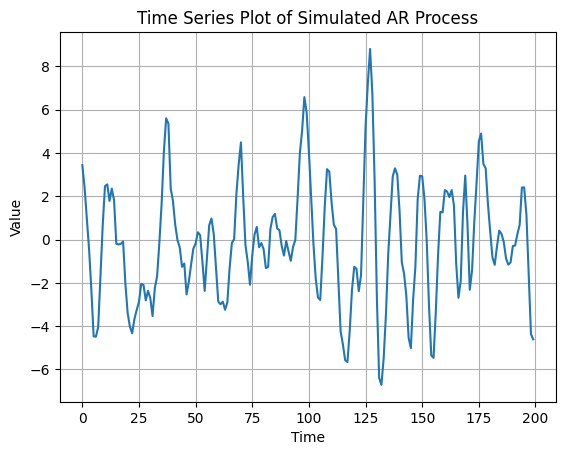

In [91]:
plot_ar_data(simulated_data)

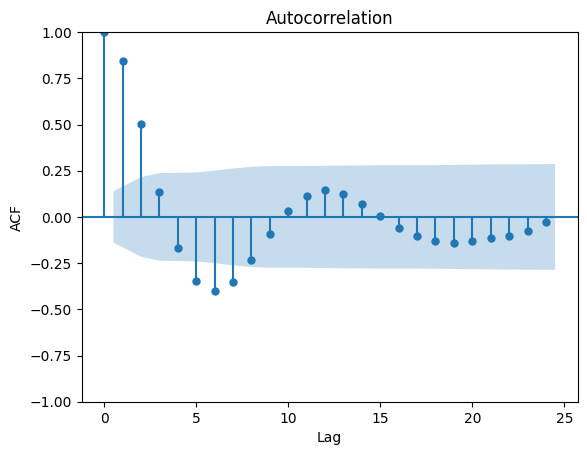

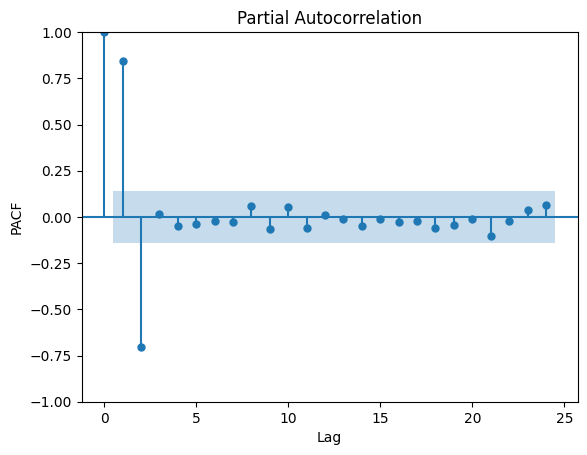

In [92]:
#画出acf和pacf
plot_acf_pacf(simulated_data)

In [93]:
import numpy as np
import statsmodels.api as sm

# 假设 data 是你的时间序列数据
data = simulated_data.copy()

# 使用 AutoReg 模型拟合数据
model = sm.tsa.AutoReg(data, lags=2, trend='n') # lags=2 指定 AR(2) 模型, 'n' 表示无常数项
model_fit = model.fit()

# 获取估计参数
phi_estimates = model_fit.params
sigma_epsilon_squared = model_fit.sigma2

print(f'参数估计:\n phi_1={phi_estimates[0]:.4f}, phi_2={phi_estimates[1]:.4f}, sigma_epsilon^2={sigma_epsilon_squared:.4f}')

参数估计:
 phi_1=1.4940, phi_2=-0.7526, sigma_epsilon^2=0.9214


In [94]:
def Levinson(data,order):
    gamma=statsmodels.tsa.stattools.acf(data,nlags=order)
    n=len(gamma)-1
    a=np.zeros((n+1,n+1))
    sigma=np.zeros(n+1)
    sigma[0]=gamma[0]
    a[1,1]=gamma[1]/gamma[0]
    for k in range(1,n):
        sigma[k]=sigma[k-1]*(1-a[k,k]**2)
        a[k+1,k+1]=(gamma[k+1]-np.dot(a[k,1:k+1],gamma[k:0:-1]))/(gamma[0]-np.dot(a[k,1:k+1],gamma[1:k+1]))
        for j in range(1,k+1):
            a[k+1,j]=a[k,j]-a[k+1,k+1]*a[k,k+1-j]
    return a,sigma
data=simulated_data.copy()
A,sigma=Levinson(data,2)
print(f'phi和sigma^2的估计分别为{A[-1,1:]}和{sigma[-2]}')

phi和sigma^2的估计分别为[ 1.43451389 -0.7032256 ]和0.29064250552325277


# 第二题
![](img/3_2.png)

（1）画出理论谱密度

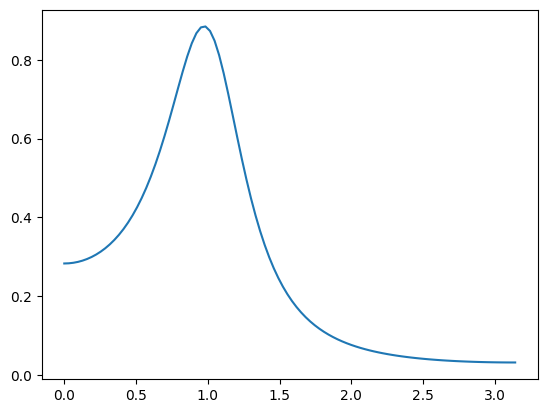

In [95]:
#计算理论谱密度
#虚数单位
ar_args=np.array([1,-0.75,0.5])
def theoretical_psd(omega,ar_args):
    return 1/(np.pi*2*np.abs(ar_args[0]+ar_args[1]*np.exp(omega*1j)+ar_args[2]*np.exp(omega*2j))**2)
plt.plot(np.linspace(0,np.pi,100),theoretical_psd(np.linspace(0,np.pi,100),ar_args))
plt.show()
#积分
#from scipy import integrate
#def theoretical_psd_integral(omega,ar_args):
#    return integrate.quad(theoretical_psd,0,omega,args=(ar_args))[0]
#plt.plot(np.linspace(0,np.pi,100),[theoretical_psd_integral(omega,ar_args) for omega in np.linspace(0,np.pi,100)])
#plt.show()

（2）白噪声检验，acf,pacf图

In [96]:
ar_args=np.array([1,-0.75,0.5])
n,bn=550,50
simulated_data=generate_ar_data(ar_args,n,bn)
#白噪声检验
statsmodels.stats.diagnostic.acorr_ljungbox(simulated_data,lags=1)#lags=1表示检验1阶自相关系数

,lb_stat,lb_pvalue
1,117.295164,2.473728e-27


经过白噪声检验，p值为e-29量级，可以认为数据不是白噪声

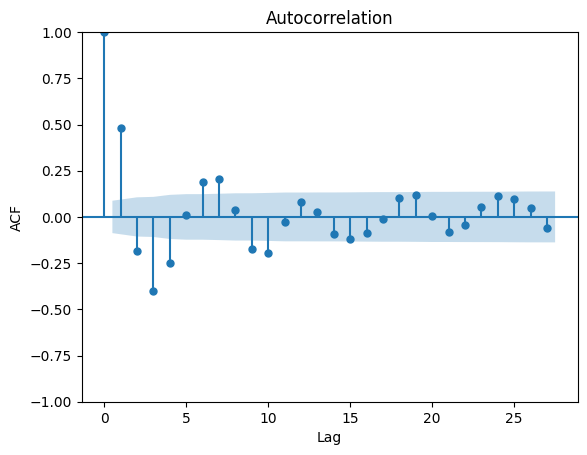

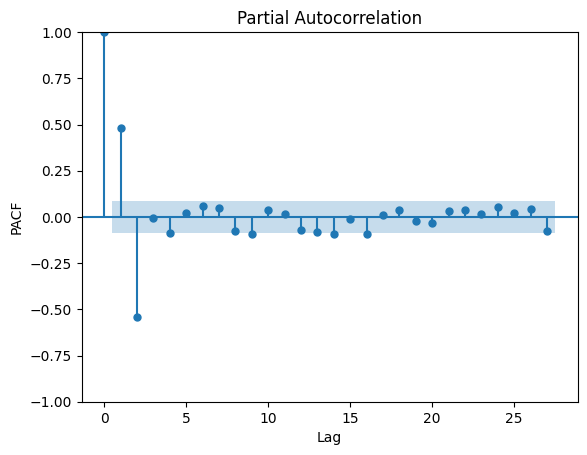

In [97]:
#画出acf和pacf
gamma=statsmodels.tsa.stattools.acf(data,nlags=2)
plot_acf_pacf(simulated_data)

通过数据估计参数，并画出数值谱密度图与理论谱密度图对比

In [98]:
# 使用 AutoReg 模型拟合数据
data=simulated_data.copy()
model = sm.tsa.AutoReg(data, lags=2, trend='n') # lags=2 指定 AR(2) 模型, 'n' 表示无常数项
model_fit = model.fit()

# 获取估计参数
phi_estimates = model_fit.params
sigma_epsilon_squared = model_fit.sigma2

print(f'参数估计:\n phi_1={phi_estimates[0]:.4f}, phi_2={phi_estimates[1]:.4f}, sigma_epsilon^2={sigma_epsilon_squared:.4f}')

参数估计:
 phi_1=0.7493, phi_2=-0.5468, sigma_epsilon^2=1.0626


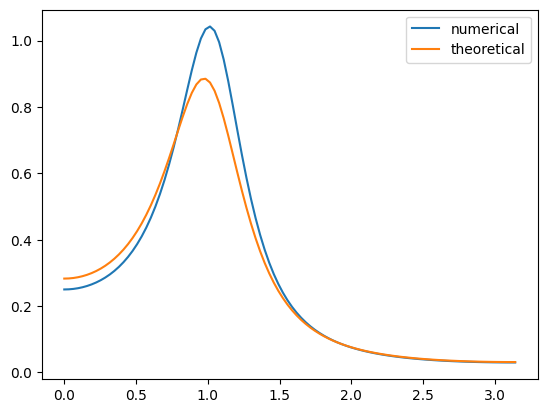

In [99]:
ar_args_numerical=np.array([1,-model_fit.params[0],-model_fit.params[1]])
ar_args=np.array([1,-0.75,0.5])
plt.plot(np.linspace(0,np.pi,100),theoretical_psd(np.linspace(0,np.pi,100),ar_args_numerical),label='numerical')
plt.plot(np.linspace(0,np.pi,100),theoretical_psd(np.linspace(0,np.pi,100),ar_args),label='theoretical')
plt.legend()
plt.show()

# 第三题
![](img/3_3.png)

In [100]:
import pandas as pd
df=pd.read_table('data/q-gdpmc1.txt',sep='\s+')#sep='\s+'表示分隔符是空格
df.head()

,year,month,day,gdp
0,1947,1,1,1770691
1,1947,4,1,1767976
2,1947,7,1,1766523
3,1947,10,1,1793310
4,1948,1,1,1821809


1) 画出时序图，考虑做对数差分 GDP（GDP 增长率）Yt

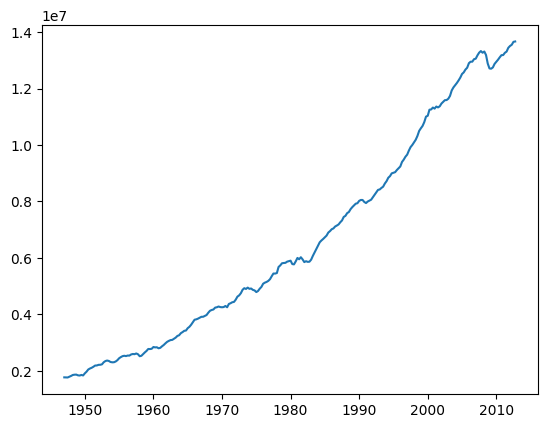

In [101]:
#画出时序图
#合并year,month,day为time_line
time_line=pd.to_datetime(df[['year','month','day']])
plt.plot(time_line,df['gdp'])
plt.show()

In [102]:
#Y_t为对数差分gdp
Y_t=np.log(df['gdp']).diff()
df['Y_t']=Y_t
df.head()

,year,month,day,gdp,Y_t
0,1947,1,1,1770691,NaN
1,1947,4,1,1767976,-0.001534
2,1947,7,1,1766523,-0.000822
3,1947,10,1,1793310,0.015050
4,1948,1,1,1821809,0.015767


2) 画出 Yt 的时序图，做白噪声检验，并做均值是否为零的检验（t 检验）

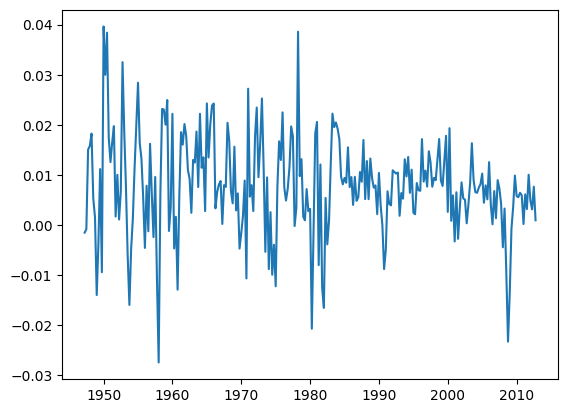

In [103]:
plt.plot(time_line[1:],Y_t[1:])
plt.show()

In [104]:
#白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(Y_t[1:],lags=1)

,lb_stat,lb_pvalue
1,36.41697,1.593101e-09


p值为e-9量级，可以认为数据不是白噪声

In [105]:
#做均值是否为0的t检验
print(f'Y_t的均值为:{Y_t[1:].mean()}')
print(f't检验统计量为:{np.sqrt(len(Y_t[1:]))*Y_t[1:].mean()/Y_t[1:].std()},t_{len(Y_t[1:])-1}的0.05分位数为{scipy.stats.t.ppf(0.975,len(Y_t[1:])-1)}')
scipy.stats.ttest_1samp(Y_t[1:],0)#0表示检验的均值

Y_t的均值为:0.0077699636682053135
t检验统计量为:12.786025792987806,t_262的0.05分位数为1.9690597152559444


TtestResult(statistic=12.786025792987807, pvalue=2.048587384472429e-29, df=262)

p值为e-29量级，可以认为均值不为0

3) 画出 Yt 的 acf 和 pacf 图，确定 AR 模型，定阶并做估计

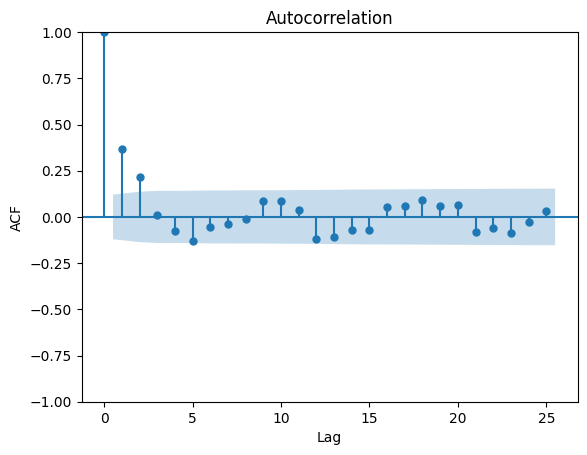

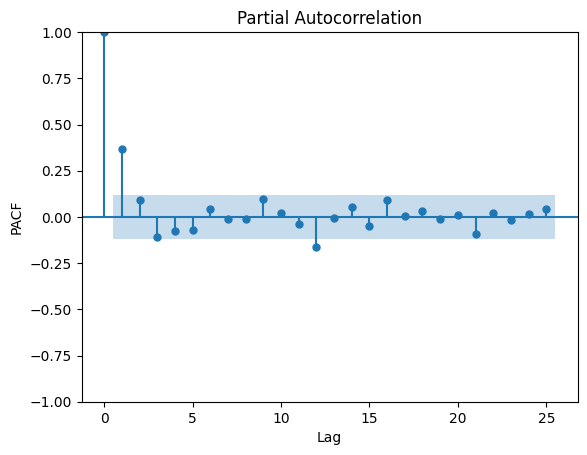

In [106]:
plot_acf_pacf(Y_t[1:])

通过观察pacf图发现，在滞后 1 和 2 时，PACF 值显著大于零（阴影区域表示95% 置信区间）。
从滞后 3 开始，PACF 值落在置信区间内，表明它们不再显著。
于是我们定阶为 AR(2) 模型。

In [107]:
#用AR(2)模型拟合数据
Y_t=Y_t.dropna().reset_index(drop=True)#drop=true
# 意味着重置索引时，原索引不会被保留，也就是说，原索引被完全丢弃，并且不会出现在新的数据帧中
model_ar2=statsmodels.api.tsa.AutoReg(Y_t,lags=2,trend='n')#trend='n'表示无常数项
model_ar2_fit=model_ar2.fit()
#获取估计参数
phi_estimates=model_ar2_fit.params
sigma_epsilon_squared=model_ar2_fit.sigma2
print(f'参数估计:\n phi_1={phi_estimates[0]:.4f}, phi_2={phi_estimates[1]:.4f}, sigma_epsilon^2={sigma_epsilon_squared:.4f}')
print(f'\n估计的AR2模型为:\n Y_t={phi_estimates[0]:.4f}*Y_t-1+{phi_estimates[1]:.4f}*Y_t-2+e_t'
      f'\n其中e_t为白噪声，方差为{sigma_epsilon_squared:.4f}')

参数估计:
 phi_1=0.4742, phi_2=0.2273, sigma_epsilon^2=0.0001

估计的AR2模型为:
 Y_t=0.4742*Y_t-1+0.2273*Y_t-2+e_t
其中e_t为白噪声，方差为0.0001


4) 画出谱密度图

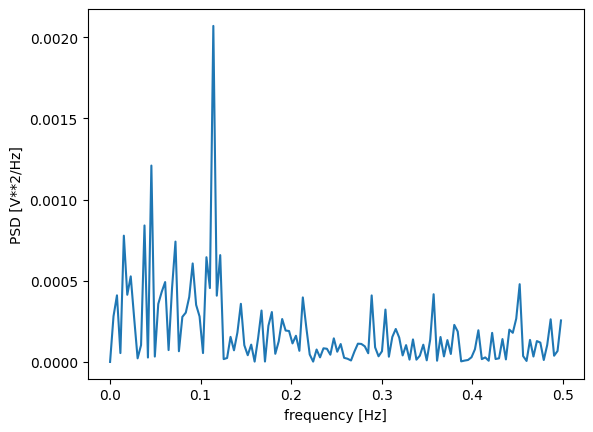

In [108]:
#根据Y_t数据画出谱密度图,并非理论谱密度图
from scipy import signal
f, Pxx_den = signal.periodogram(Y_t)
plt.plot(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()